In [1]:
#Colab Setup
%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/gdrive')

!pip install pymorphy2

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 7.1MB 8.2MB/s 
Tue Jun 23 12:53:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| 

In [2]:
import sys
sys.path.append("/content/gdrive/My Drive/smu-ABAE/classes")

review_corpus_path = "/content/gdrive/My Drive/smu-ABAE/data/tech_review_sent_corpus.pkl"
vocab_path = "/content/gdrive/My Drive/smu-ABAE/data/vocab-text-review.txt"
emb_filename = '/content/gdrive/My Drive/smu-ABAE/models/w2v_embedding'
aspect_output_path = '/content/gdrive/My Drive/smu-ABAE/results/ABAE'
stop_words_path = "/content/gdrive/My Drive/smu-ABAE/data/stop_words.json"

In [3]:
# import sys
# import os

# module_path = os.path.abspath(os.path.join(".."))
# if module_path not in sys.path:
#     sys.path.append(module_path+"/scripts")
#     sys.path.append(module_path+"/classes")

# review_corpus_path = "../data/tech_review_sent_corpus.pkl"
# vocab_path = "../data/glove-tech-revew-vocab.txt"
# emb_filename = '../models/w2v_embedding'
# aspect_output_path = "../results/ABAE"
# vocab_path = "../data/vocab-text-review.txt"


In [4]:
import pandas as pd
import pickle

with open(review_corpus_path,"rb") as f:
    tech_review_corpus = pickle.load(f)

print(len(tech_review_corpus))
display(pd.DataFrame(tech_review_corpus).head(10))

148431


,index,review
0,299,fluor be a great company with people that care...
1,299,management care about their employee as well a...
2,1145,fluor be the first powerhouse epc that go heav...
3,1145,they send as much work overseas a possible and...
4,1145,this be a heavy load company with management
5,1145,fluor chase the big project and will hire thou...
6,1145,in turn they will lay off thousand when it go
7,1145,fluor have the sharp spike in hiring and lay off
8,1145,the employee be clearly not their great asset
9,1375,there be not much that i could add here


## Parmeters

In [5]:
from numpy.random import seed
import tensorflow as tf
seed(76244)
tf.random.set_seed(76244)

import ABAE.utils as U
parser = U.add_common_args()

Using TensorFlow backend.


## Setup Data

100%|██████████| 148431/148431 [00:13<00:00, 10626.49it/s]


Max Character length 1238
Average Character Length 43.68635931847121
Standard Deviation 33.793819520019184
Median Character Length 36.0
Words 2 standard deviations from mean 111.27399835850957


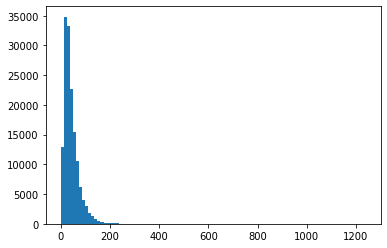

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from multiprocessing import Pool

with open(stop_words_path, "r") as f:
  stop_words = json.load(f)

def removeStopWords(review):
  tokens = review.split(" ")
  return " ".join([ word for word in tokens if word not in stop_words ])

reviews = pd.DataFrame(tech_review_corpus).review.tolist()

with Pool() as p:
  reviews = list(tqdm(p.imap(removeStopWords, reviews), total=len(reviews)))

word_length = [ len(review) for review in reviews ]

print("Max Character length", max(word_length))
print("Average Character Length", np.mean(word_length))
print("Standard Deviation", np.std(word_length))
print("Median Character Length", np.median(word_length))
print("Words 2 standard deviations from mean", np.mean(word_length) + (2*np.std(word_length)))

plt.hist(word_length,bins=100)
plt.show()

In [7]:
from keras.preprocessing import sequence
import ABAE.reader as dataset

#Paramaters
maxlen = 112 #Based on 2 standard deviations from mean

vocab, train_x, overall_maxlen = dataset.get_data(reviews, vocab_path, vocab_size=0, maxlen=maxlen)
train_x = sequence.pad_sequences(train_x, maxlen=overall_maxlen)

vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w
    
# train_x = train_x[0:30000]
print('Number of training examples: ', len(train_x))
print('Length of vocab: ', len(vocab))

 Creating vocab ...
   937026 total words, 25823 unique words
 Reading dataset ...
  train set
Corpus Size 148431
Total Document Analyzed 148431
<num> hit rate: 1.01%, <unk> hit rate: 0.00%
Number of training examples:  148431
Length of vocab:  25826


In [8]:
print(reviews[20])
print( [ vocab_inv[i] for i in train_x[20]] )

infrastructure adequately maintain except maybe escalator
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

## Attention-Based-Aspect-Detection Code

In [9]:
import importlib
# import ABAE.model
# import ABAE.w2vEmbReader
import ABAE.train
# import ABAE.reader
# importlib.reload(ABAE.model)
# importlib.reload(ABAE.w2vEmbReader)
importlib.reload(ABAE.train)
# importlib.reload(ABAE.reader)

<module 'ABAE.train' from '/content/gdrive/My Drive/smu-ABAE/classes/ABAE/train.py'>

In [10]:
import os
from ABAE.w2vEmbReader import W2VEmbReader as EmbReader

emb_reader = EmbReader(emb_filename)

2020-06-23 12:53:28,373 INFO Loading embeddings from: /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
2020-06-23 12:53:28,374 INFO loading Word2VecKeyedVectors object from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-23 12:53:30,136 INFO loading wv recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.wv.* with mmap=None
2020-06-23 12:53:30,137 INFO setting ignored attribute vectors_norm to None
2020-06-23 12:53:30,139 INFO loading vocabulary recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.vocabulary.* with mmap=None
2020-06-23 12:53:30,140 INFO loading trainables recursiv

  #vectors: 51445, #dimensions: 200


In [11]:
import ABAE.model as m
from ABAE.train import train
from ABAE.optimizers import get_optimizer, sentence_batch_generator, negative_batch_generator
import itertools


emb_dim = 200
neg_sizes = [10,20,30,40,50]
aspect_sizes = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
ortho_regs = [0.01, 0.1, 0.25, 0.5, 0.75, 1]
batch_size = 50
epochs = 15
import json

parameters = list(itertools.product(aspect_sizes, ortho_regs,neg_sizes))

optimizer = get_optimizer("adam")

for param in tqdm(parameters):
    k = param[0]
    ortho_reg = param[1]
    neg_size = param[2]
    
    aspect_file_name = "abae-k-{0}-orth-{1}-neg-{2}".format(k, ortho_reg,neg_size)
    aspect_file_name = os.path.join(aspect_output_path,aspect_file_name)

    if not os.path.isfile(aspect_file_name + ".json"):
      print("\n")
      print("="*80)
      print("Running for k={0}, ortho_reg={1}, neg_size={2}".format(k, ortho_reg, neg_size))
      model = m.create_model(overall_maxlen, vocab, k, neg_size, emb_reader, ortho_reg)
      # freeze the word embedding layer
      model.get_layer('word_emb').trainable = False
      model.compile(optimizer=optimizer, loss=U.max_margin_loss, metrics=[U.max_margin_loss])

      sen_gen = sentence_batch_generator(train_x, batch_size)
      neg_gen = negative_batch_generator(train_x, batch_size, neg_size)
      batches_per_epoch = len(train_x) // batch_size

      aspect, model = train(model, sen_gen, neg_gen, epochs, batch_size, batches_per_epoch, aspect_file_name, vocab_inv)

      model.save(aspect_file_name)
      with open(aspect_file_name + ".json", "w") as f:
          json.dump(aspect, f)
 
      print("="*80)

 62%|██████▏   | 204/330 [00:02<03:13,  1.54s/it]



Running for k=13, ortho_reg=0.1, neg_size=30


 62%|██████▏   | 204/330 [00:19<03:13,  1.54s/it]

Epoch 14, train: 384s
Total loss: 7.8027, max_margin_loss: 7.6932, ortho_reg: 0.1095


 75%|███████▌  | 248/330 [06:47<05:14,  3.84s/it]



Running for k=13, ortho_reg=0.1, neg_size=40


 75%|███████▌  | 249/330 [13:43<2:51:56, 127.36s/it]

Epoch 14, train: 394s
Total loss: 9.8820, max_margin_loss: 9.7719, ortho_reg: 0.1101


Running for k=13, ortho_reg=0.1, neg_size=50


 76%|███████▌  | 250/330 [21:00<4:53:51, 220.39s/it]

Epoch 14, train: 416s
Total loss: 12.7525, max_margin_loss: 12.6423, ortho_reg: 0.1102


Running for k=13, ortho_reg=0.25, neg_size=10


 76%|███████▌  | 251/330 [27:07<5:47:50, 264.18s/it]

Epoch 14, train: 345s
Total loss: 2.6829, max_margin_loss: 2.4118, ortho_reg: 0.2711


Running for k=13, ortho_reg=0.25, neg_size=20


 76%|███████▋  | 252/330 [33:17<6:24:43, 295.94s/it]

Epoch 14, train: 349s
Total loss: 5.1401, max_margin_loss: 4.8681, ortho_reg: 0.2719


Running for k=13, ortho_reg=0.25, neg_size=30


 77%|███████▋  | 253/330 [39:42<6:54:19, 322.85s/it]

Epoch 14, train: 365s
Total loss: 7.4608, max_margin_loss: 7.1878, ortho_reg: 0.2730


Running for k=13, ortho_reg=0.25, neg_size=40


 77%|███████▋  | 254/330 [46:24<7:18:56, 346.54s/it]

Epoch 14, train: 382s
Total loss: 9.8591, max_margin_loss: 9.5865, ortho_reg: 0.2726


Running for k=13, ortho_reg=0.25, neg_size=50


 77%|███████▋  | 255/330 [53:34<7:44:13, 371.38s/it]

Epoch 14, train: 410s
Total loss: 12.2613, max_margin_loss: 11.9887, ortho_reg: 0.2725


Running for k=13, ortho_reg=0.5, neg_size=10


 78%|███████▊  | 256/330 [59:31<7:32:52, 367.20s/it]

Epoch 14, train: 338s
Total loss: 2.9546, max_margin_loss: 2.4130, ortho_reg: 0.5415


Running for k=13, ortho_reg=0.5, neg_size=20


 78%|███████▊  | 257/330 [1:05:36<7:25:50, 366.45s/it]

Epoch 14, train: 345s
Total loss: 5.4187, max_margin_loss: 4.8764, ortho_reg: 0.5423


Running for k=13, ortho_reg=0.5, neg_size=30


 78%|███████▊  | 258/330 [1:11:50<7:22:41, 368.90s/it]

Epoch 14, train: 355s
Total loss: 7.8398, max_margin_loss: 7.2967, ortho_reg: 0.5431


Running for k=13, ortho_reg=0.5, neg_size=40


 78%|███████▊  | 259/330 [1:18:34<7:28:49, 379.28s/it]

Epoch 14, train: 384s
Total loss: 10.1231, max_margin_loss: 9.5797, ortho_reg: 0.5434


Running for k=13, ortho_reg=0.5, neg_size=50


 79%|███████▉  | 260/330 [1:25:44<7:40:10, 394.43s/it]

Epoch 14, train: 410s
Total loss: 12.6753, max_margin_loss: 12.1310, ortho_reg: 0.5442


Running for k=13, ortho_reg=0.75, neg_size=10


 79%|███████▉  | 261/330 [1:31:44<7:21:56, 384.30s/it]

Epoch 14, train: 342s
Total loss: 3.2493, max_margin_loss: 2.4375, ortho_reg: 0.8118


Running for k=13, ortho_reg=0.75, neg_size=20


 79%|███████▉  | 262/330 [1:37:47<7:08:02, 377.68s/it]

Epoch 14, train: 343s
Total loss: 5.7063, max_margin_loss: 4.8937, ortho_reg: 0.8127


Running for k=13, ortho_reg=0.75, neg_size=30


 80%|███████▉  | 263/330 [1:44:03<7:01:22, 377.35s/it]

Epoch 14, train: 358s
Total loss: 7.9854, max_margin_loss: 7.1717, ortho_reg: 0.8137


Running for k=13, ortho_reg=0.75, neg_size=40


 80%|████████  | 264/330 [1:50:41<7:01:54, 383.55s/it]

Epoch 14, train: 379s
Total loss: 10.4038, max_margin_loss: 9.5900, ortho_reg: 0.8138


Running for k=13, ortho_reg=0.75, neg_size=50


 80%|████████  | 265/330 [1:57:59<7:12:59, 399.68s/it]

Epoch 14, train: 418s
Total loss: 13.0309, max_margin_loss: 12.2162, ortho_reg: 0.8147


Running for k=13, ortho_reg=1, neg_size=10


 81%|████████  | 266/330 [2:03:43<6:48:38, 383.10s/it]

Epoch 14, train: 326s
Total loss: 3.5149, max_margin_loss: 2.4329, ortho_reg: 1.0820


Running for k=13, ortho_reg=1, neg_size=20


 81%|████████  | 267/330 [2:09:51<6:37:37, 378.68s/it]

Epoch 14, train: 349s
Total loss: 5.8784, max_margin_loss: 4.7957, ortho_reg: 1.0827


Running for k=13, ortho_reg=1, neg_size=30


 81%|████████  | 268/330 [2:16:07<6:30:17, 377.71s/it]

Epoch 14, train: 355s
Total loss: 8.3937, max_margin_loss: 7.3099, ortho_reg: 1.0838


Running for k=13, ortho_reg=1, neg_size=40


 82%|████████▏ | 269/330 [2:22:41<6:28:54, 382.52s/it]

Epoch 14, train: 375s
Total loss: 10.7415, max_margin_loss: 9.6572, ortho_reg: 1.0843


Running for k=13, ortho_reg=1, neg_size=50


 82%|████████▏ | 270/330 [2:30:06<6:41:18, 401.32s/it]

Epoch 14, train: 424s
Total loss: 13.0146, max_margin_loss: 11.9298, ortho_reg: 1.0848


Running for k=14, ortho_reg=0.01, neg_size=10


 82%|████████▏ | 271/330 [2:36:23<6:27:34, 394.15s/it]

Epoch 14, train: 358s
Total loss: 2.3148, max_margin_loss: 2.3037, ortho_reg: 0.0111


Running for k=14, ortho_reg=0.01, neg_size=20


 82%|████████▏ | 272/330 [2:42:35<6:14:26, 387.35s/it]

Epoch 14, train: 352s
Total loss: 4.9372, max_margin_loss: 4.9256, ortho_reg: 0.0116


Running for k=14, ortho_reg=0.01, neg_size=30


 83%|████████▎ | 273/330 [2:48:55<6:06:06, 385.37s/it]

Epoch 14, train: 362s
Total loss: 7.0647, max_margin_loss: 7.0524, ortho_reg: 0.0122


Running for k=14, ortho_reg=0.01, neg_size=40


 83%|████████▎ | 274/330 [2:55:50<6:07:49, 394.11s/it]

Epoch 14, train: 395s
Total loss: 9.2303, max_margin_loss: 9.2176, ortho_reg: 0.0126


Running for k=14, ortho_reg=0.01, neg_size=50


 83%|████████▎ | 275/330 [3:02:59<6:10:59, 404.72s/it]

Epoch 14, train: 410s
Total loss: 11.3551, max_margin_loss: 11.3418, ortho_reg: 0.0133


Running for k=14, ortho_reg=0.1, neg_size=10


 84%|████████▎ | 276/330 [3:09:17<5:56:53, 396.54s/it]

Epoch 14, train: 357s
Total loss: 2.4568, max_margin_loss: 2.3485, ortho_reg: 0.1083


Running for k=14, ortho_reg=0.1, neg_size=20


 84%|████████▍ | 277/330 [3:15:51<5:49:38, 395.82s/it]

Epoch 14, train: 374s
Total loss: 4.8315, max_margin_loss: 4.7230, ortho_reg: 0.1085


Running for k=14, ortho_reg=0.1, neg_size=30


 84%|████████▍ | 278/330 [3:22:29<5:43:40, 396.56s/it]

Epoch 14, train: 378s
Total loss: 7.0454, max_margin_loss: 6.9366, ortho_reg: 0.1088


Running for k=14, ortho_reg=0.1, neg_size=40


 85%|████████▍ | 279/330 [3:29:22<5:41:07, 401.33s/it]

Epoch 14, train: 393s
Total loss: 9.3321, max_margin_loss: 9.2229, ortho_reg: 0.1092


Running for k=14, ortho_reg=0.1, neg_size=50


 85%|████████▍ | 280/330 [3:36:30<5:41:13, 409.47s/it]

Epoch 14, train: 409s
Total loss: 11.8986, max_margin_loss: 11.7891, ortho_reg: 0.1095


Running for k=14, ortho_reg=0.25, neg_size=10


 85%|████████▌ | 281/330 [3:42:27<5:21:32, 393.73s/it]

Epoch 14, train: 338s
Total loss: 2.6309, max_margin_loss: 2.3612, ortho_reg: 0.2697


Running for k=14, ortho_reg=0.25, neg_size=20


 85%|████████▌ | 282/330 [3:48:33<5:08:23, 385.49s/it]

Epoch 14, train: 348s
Total loss: 4.8860, max_margin_loss: 4.6159, ortho_reg: 0.2701


Running for k=14, ortho_reg=0.25, neg_size=30


 86%|████████▌ | 283/330 [3:54:58<5:01:48, 385.29s/it]

Epoch 14, train: 367s
Total loss: 7.1981, max_margin_loss: 6.9275, ortho_reg: 0.2705


Running for k=14, ortho_reg=0.25, neg_size=40


 86%|████████▌ | 284/330 [4:01:42<4:59:37, 390.81s/it]

Epoch 14, train: 386s
Total loss: 9.4937, max_margin_loss: 9.2226, ortho_reg: 0.2711


Running for k=14, ortho_reg=0.25, neg_size=50


 86%|████████▋ | 285/330 [4:09:19<5:07:56, 410.59s/it]

Epoch 14, train: 439s
Total loss: 12.6228, max_margin_loss: 12.3514, ortho_reg: 0.2713


Running for k=14, ortho_reg=0.5, neg_size=10


 87%|████████▋ | 286/330 [4:15:19<4:49:56, 395.37s/it]

Epoch 14, train: 342s
Total loss: 2.8720, max_margin_loss: 2.3335, ortho_reg: 0.5385


Running for k=14, ortho_reg=0.5, neg_size=20


 87%|████████▋ | 287/330 [4:21:26<4:37:24, 387.09s/it]

Epoch 14, train: 350s
Total loss: 5.2315, max_margin_loss: 4.6924, ortho_reg: 0.5391


Running for k=14, ortho_reg=0.5, neg_size=30


 87%|████████▋ | 288/330 [4:27:38<4:27:45, 382.52s/it]

Epoch 14, train: 354s
Total loss: 7.5393, max_margin_loss: 6.9994, ortho_reg: 0.5399


Running for k=14, ortho_reg=0.5, neg_size=40


 88%|████████▊ | 289/330 [4:34:51<4:31:41, 397.59s/it]

Epoch 14, train: 415s
Total loss: 9.9361, max_margin_loss: 9.3955, ortho_reg: 0.5407


Running for k=14, ortho_reg=0.5, neg_size=50


 88%|████████▊ | 290/330 [4:41:54<4:30:04, 405.10s/it]

Epoch 14, train: 405s
Total loss: 12.1685, max_margin_loss: 11.6275, ortho_reg: 0.5410


Running for k=14, ortho_reg=0.75, neg_size=10


 88%|████████▊ | 291/330 [4:47:58<4:15:27, 393.02s/it]

Epoch 14, train: 347s
Total loss: 3.1639, max_margin_loss: 2.3566, ortho_reg: 0.8073


Running for k=14, ortho_reg=0.75, neg_size=20


 88%|████████▊ | 292/330 [4:54:06<4:04:00, 385.28s/it]

Epoch 14, train: 349s
Total loss: 5.4977, max_margin_loss: 4.6896, ortho_reg: 0.8080


Running for k=14, ortho_reg=0.75, neg_size=30


 89%|████████▉ | 293/330 [5:00:42<3:59:35, 388.52s/it]

Epoch 14, train: 378s
Total loss: 7.7133, max_margin_loss: 6.9045, ortho_reg: 0.8088


Running for k=14, ortho_reg=0.75, neg_size=40


 89%|████████▉ | 294/330 [5:07:23<3:55:30, 392.52s/it]

Epoch 14, train: 382s
Total loss: 10.2047, max_margin_loss: 9.3949, ortho_reg: 0.8099


Running for k=14, ortho_reg=0.75, neg_size=50


 89%|████████▉ | 295/330 [5:14:42<3:56:59, 406.28s/it]

Epoch 14, train: 419s
Total loss: 12.3512, max_margin_loss: 11.5415, ortho_reg: 0.8096


Running for k=14, ortho_reg=1, neg_size=10


 90%|████████▉ | 296/330 [5:20:53<3:44:17, 395.80s/it]

Epoch 14, train: 351s
Total loss: 2.9055, max_margin_loss: 2.8802, ortho_reg: 0.0253


Running for k=14, ortho_reg=1, neg_size=20


 90%|█████████ | 297/330 [5:27:33<3:38:16, 396.87s/it]

Epoch 14, train: 380s
Total loss: 5.7060, max_margin_loss: 4.6290, ortho_reg: 1.0770


Running for k=14, ortho_reg=1, neg_size=30


 90%|█████████ | 298/330 [5:34:03<3:30:38, 394.96s/it]

Epoch 14, train: 371s
Total loss: 8.0057, max_margin_loss: 6.9280, ortho_reg: 1.0777


Running for k=14, ortho_reg=1, neg_size=40


 91%|█████████ | 299/330 [5:40:58<3:27:13, 401.07s/it]

Epoch 14, train: 395s
Total loss: 10.2865, max_margin_loss: 9.2086, ortho_reg: 1.0779


Running for k=14, ortho_reg=1, neg_size=50


 91%|█████████ | 300/330 [5:48:32<3:28:26, 416.88s/it]

Epoch 14, train: 434s
Total loss: 12.8143, max_margin_loss: 11.7354, ortho_reg: 1.0790


Running for k=15, ortho_reg=0.01, neg_size=10


 91%|█████████ | 301/330 [5:55:02<3:17:33, 408.74s/it]

Epoch 14, train: 367s
Total loss: 2.3851, max_margin_loss: 2.3739, ortho_reg: 0.0111


Running for k=15, ortho_reg=0.01, neg_size=20


 92%|█████████▏| 302/330 [6:01:27<3:07:25, 401.61s/it]

Epoch 14, train: 362s
Total loss: 4.4636, max_margin_loss: 4.4521, ortho_reg: 0.0115


Running for k=15, ortho_reg=0.01, neg_size=30


 92%|█████████▏| 303/330 [6:08:06<3:00:19, 400.72s/it]

Epoch 14, train: 376s
Total loss: 7.1561, max_margin_loss: 7.1440, ortho_reg: 0.0121


Running for k=15, ortho_reg=0.01, neg_size=40


 92%|█████████▏| 304/330 [6:15:09<2:56:38, 407.63s/it]

Epoch 14, train: 401s
Total loss: 8.9010, max_margin_loss: 8.8882, ortho_reg: 0.0127


Running for k=15, ortho_reg=0.01, neg_size=50


 92%|█████████▏| 305/330 [6:22:39<2:55:09, 420.40s/it]

Epoch 14, train: 427s
Total loss: 11.7949, max_margin_loss: 11.7824, ortho_reg: 0.0125


Running for k=15, ortho_reg=0.1, neg_size=10


 93%|█████████▎| 306/330 [6:28:59<2:43:16, 408.19s/it]

Epoch 14, train: 357s
Total loss: 2.4840, max_margin_loss: 2.3764, ortho_reg: 0.1076


Running for k=15, ortho_reg=0.1, neg_size=20


 93%|█████████▎| 307/330 [6:35:21<2:33:26, 400.28s/it]

Epoch 14, train: 360s
Total loss: 4.6052, max_margin_loss: 4.4971, ortho_reg: 0.1082


Running for k=15, ortho_reg=0.1, neg_size=30


 93%|█████████▎| 308/330 [6:41:59<2:26:33, 399.69s/it]

Epoch 14, train: 376s
Total loss: 6.8351, max_margin_loss: 6.7268, ortho_reg: 0.1084


Running for k=15, ortho_reg=0.1, neg_size=40


 94%|█████████▎| 309/330 [6:48:53<2:21:19, 403.78s/it]

Epoch 14, train: 391s
Total loss: 8.9831, max_margin_loss: 8.8741, ortho_reg: 0.1090


Running for k=15, ortho_reg=0.1, neg_size=50


 94%|█████████▍| 310/330 [6:56:20<2:18:54, 416.71s/it]

Epoch 14, train: 424s
Total loss: 11.3032, max_margin_loss: 11.1943, ortho_reg: 0.1089


Running for k=15, ortho_reg=0.25, neg_size=10


 94%|█████████▍| 311/330 [7:02:51<2:09:35, 409.21s/it]

Epoch 14, train: 369s
Total loss: 2.5005, max_margin_loss: 2.2323, ortho_reg: 0.2682


Running for k=15, ortho_reg=0.25, neg_size=20


 95%|█████████▍| 312/330 [7:09:25<2:01:23, 404.66s/it]

Epoch 14, train: 371s
Total loss: 4.9513, max_margin_loss: 4.6822, ortho_reg: 0.2691


Running for k=15, ortho_reg=0.25, neg_size=30


 95%|█████████▍| 313/330 [7:16:24<1:55:49, 408.82s/it]

Epoch 14, train: 396s
Total loss: 6.8885, max_margin_loss: 6.6189, ortho_reg: 0.2696


Running for k=15, ortho_reg=0.25, neg_size=40


 95%|█████████▌| 314/330 [7:23:18<1:49:26, 410.43s/it]

Epoch 14, train: 391s
Total loss: 9.2516, max_margin_loss: 8.9824, ortho_reg: 0.2691


Running for k=15, ortho_reg=0.25, neg_size=50


 95%|█████████▌| 315/330 [7:30:51<1:45:49, 423.28s/it]

Epoch 14, train: 430s
Total loss: 11.4604, max_margin_loss: 11.1903, ortho_reg: 0.2701


Running for k=15, ortho_reg=0.5, neg_size=10


 96%|█████████▌| 316/330 [7:37:02<1:35:03, 407.42s/it]

Epoch 14, train: 348s
Total loss: 2.7742, max_margin_loss: 2.2385, ortho_reg: 0.5357


Running for k=15, ortho_reg=0.5, neg_size=20


 96%|█████████▌| 317/330 [7:43:20<1:26:23, 398.70s/it]

Epoch 14, train: 357s
Total loss: 5.0150, max_margin_loss: 4.4786, ortho_reg: 0.5364


Running for k=15, ortho_reg=0.5, neg_size=30


 96%|█████████▋| 318/330 [7:50:08<1:20:19, 401.61s/it]

Epoch 14, train: 386s
Total loss: 7.2440, max_margin_loss: 6.7067, ortho_reg: 0.5373


Running for k=15, ortho_reg=0.5, neg_size=40


 97%|█████████▋| 319/330 [7:57:07<1:14:34, 406.73s/it]

Epoch 14, train: 396s
Total loss: 9.4776, max_margin_loss: 8.9404, ortho_reg: 0.5372


Running for k=15, ortho_reg=0.5, neg_size=50


 97%|█████████▋| 320/330 [8:04:32<1:09:41, 418.15s/it]

Epoch 14, train: 422s
Total loss: 11.7114, max_margin_loss: 11.1727, ortho_reg: 0.5387


Running for k=15, ortho_reg=0.75, neg_size=10


 97%|█████████▋| 321/330 [8:10:44<1:00:39, 404.39s/it]

Epoch 14, train: 350s
Total loss: 3.0383, max_margin_loss: 2.2351, ortho_reg: 0.8032


Running for k=15, ortho_reg=0.75, neg_size=20


 98%|█████████▊| 322/330 [8:17:12<53:15, 399.43s/it]  

Epoch 14, train: 365s
Total loss: 5.2719, max_margin_loss: 4.4679, ortho_reg: 0.8039


Running for k=15, ortho_reg=0.75, neg_size=30


 98%|█████████▊| 323/330 [8:23:53<46:39, 399.94s/it]

Epoch 14, train: 378s
Total loss: 7.4874, max_margin_loss: 6.6827, ortho_reg: 0.8047


Running for k=15, ortho_reg=0.75, neg_size=40


 98%|█████████▊| 324/330 [8:30:45<40:21, 403.65s/it]

Epoch 14, train: 390s
Total loss: 9.7437, max_margin_loss: 8.9386, ortho_reg: 0.8051


Running for k=15, ortho_reg=0.75, neg_size=50


 98%|█████████▊| 325/330 [8:38:17<34:50, 418.03s/it]

Epoch 14, train: 429s
Total loss: 11.9753, max_margin_loss: 11.1689, ortho_reg: 0.8064


Running for k=15, ortho_reg=1, neg_size=10


 99%|█████████▉| 326/330 [8:44:40<27:09, 407.45s/it]

Epoch 14, train: 360s
Total loss: 3.3014, max_margin_loss: 2.2309, ortho_reg: 1.0705


Running for k=15, ortho_reg=1, neg_size=20


 99%|█████████▉| 327/330 [8:51:13<20:09, 403.03s/it]

Epoch 14, train: 370s
Total loss: 5.6383, max_margin_loss: 4.5667, ortho_reg: 1.0716


Running for k=15, ortho_reg=1, neg_size=30


 99%|█████████▉| 328/330 [8:58:02<13:30, 405.05s/it]

Epoch 14, train: 387s
Total loss: 7.7647, max_margin_loss: 6.6920, ortho_reg: 1.0726


Running for k=15, ortho_reg=1, neg_size=40


100%|█████████▉| 329/330 [9:05:00<06:48, 408.95s/it]

Epoch 14, train: 395s
Total loss: 10.5190, max_margin_loss: 9.4461, ortho_reg: 1.0729


Running for k=15, ortho_reg=1, neg_size=50


100%|██████████| 330/330 [9:12:16<00:00, 100.41s/it]

Epoch 14, train: 414s
Total loss: 12.2406, max_margin_loss: 11.1664, ortho_reg: 1.0742
